# **Spotify Music Dataset : Prédiction de popularité d'un morceau**

## **Description des données**

Les données sont disponibles sur [Kaggle: Spotify Music Dataset](https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset?resource=download): 

| **Variable** | **Description** |
|----------|-------------|
| **Energy** | A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. |
| **Tempo** | The speed of a track, measured in beats per minute (BPM). |
| **Danceability** | A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity. |
| **Loudness** | The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall. |
| **Liveness** | The likelihood of a track being performed live. Higher values suggest more audience presence. |
| **Valence** | The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry. |
| **Speechiness** | Measures the presence of spoken words. |
| **Instrumentalness** | The likelihood a track contains no vocals. Values closer to 1.0 suggest solely instrumental tracks. |
| **Mode** | Indicates the modality of the track. |
| **Key** | The musical key, represented as an integer from 0 to 11, mapping to standard Pitch class notation. |
| **Duration_ms** | The length of the track in milliseconds. |
| **Acousticness** | A confidence measure of whether a track is acoustic(1) or not(0). |
| **Track Name** | The name of the track. |
| **Track Artist** | The artist(s) performing the track. |
| **Track Album Name** | The album in which the track is featured. |
| **Track Album Release Date** | The release date of the album containing the track. |
| **Track ID** | A unique identifier assigned to the track by Spotify. |
| **Track Album ID** | A unique identifier for the album. |
| **Playlist Name** | The name of the playlist where the track is included. |
| **Playlist Genre** | The main genre associated with the playlist (e.g., pop, rock, classical). |
| **Playlist Subgenre** | A more specific subgenre tied to the playlist (e.g., indie pop, punk rock). |
| **Playlist ID** | A unique identifier for the playlist. |
| **Track Popularity** | A score (0–100) which is calculated based on total number of streams in relation to other songs. |


L'idée de cette étude est de prédire la popularité d'un morceau (`Track Popularity`) avec d'autres variables quantitatives.

In [454]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance

try:
    from alibi.explainers import ALE
    import lime
    import lime.lime_tabular
    import shap
    EXPLAIN_LIBS_AVAILABLE = True
except ImportError:
    print("Certaines bibliothèques d'explicabilité ne sont pas disponibles.")
    print("Installation recommandée: pip install shap alibi lime")
    EXPLAIN_LIBS_AVAILABLE = False

Certaines bibliothèques d'explicabilité ne sont pas disponibles.
Installation recommandée: pip install shap alibi lime


In [408]:
# Création du dossier pour les images
os.makedirs('img', exist_ok=True)

# Configuration des visualisations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Pour la reproductibilité
np.random.seed(42)

# Ignorer les warnings
import warnings
warnings.filterwarnings("ignore")

# Configuration pandas
pd.set_option('display.max_colwidth', None)


## **Définition des fonctions**

In [409]:
def winsorize_data(xtrain, xtest, feature):
    """
    Permet de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.
    Pour se prémunir d'un data leak.
    """
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return xtrain_winsorized, xtest_winsorized

def display_original_pdp_values(num_col, model, df, scaler, feature_name):
    """
    Permet d'afficher les données originales des PDP après un scaling features
    
    Args:
        num_col: Numéro de l'index de la colonne à afficher
        model: Modèle utilisé
        df: DataFrame avec vos données
        scaler: Scaler utilisé, uniquement sklearn
        feature_name: Nom de la feature pour l'affichage
    """
    features_to_plot = [(num_col,)]  # Indices des colonnes à analyser

    pdp_results = partial_dependence(model, df, features=features_to_plot, kind='average')

    # Extraire les valeurs PDP (standardisées)
    grid = pdp_results['grid_values']  # Grille de valeurs pour chaque feature
    pdp = pdp_results['average']  # Valeurs moyennes du PDP

    # Appliquer l'inverse transformation sur la grille de valeurs
    original_grid = [scaler.mean_[num_col] + grid[0] * scaler.scale_[num_col]]

    plt.figure(figsize=(10, 6))
    plt.plot(original_grid[0], pdp[0])
    plt.xlabel(f'Variable: {feature_name}')
    plt.ylabel('Partial Dependence Plot Value')
    plt.title(f'Original Partial Dependence Plot for {feature_name}')
    plt.savefig(f'img/pdp_original_{feature_name.replace(" ", "_")}.png')
    plt.close()

def calculate_age_days(date_str):
    """Calcule l'âge en jours d'un morceau depuis sa date de sortie"""
    try:
        # Convertir la date en format datetime
        date_obj = pd.to_datetime(date_str)
        # Calculer la différence en jours
        delta = datetime.now() - date_obj
        return delta.days
    except:
        # En cas d'erreur, retourner une valeur par défaut (5 ans en jours)
        return 365 * 5

def convert_date_to_numeric(date_str):
    """
    Convertit une date en valeur numérique au format YYYYMMDD
    Gère différents formats de date potentiels
    """
    try:
        # Tenter de convertir automatiquement
        date_obj = pd.to_datetime(date_str)
        return int(date_obj.strftime('%Y%m%d'))
    except:
        # Si échec, vérifier si c'est juste une année (YYYY)
        if isinstance(date_str, str) and len(date_str) == 4 and date_str.isdigit():
            # Pour une année seule, utiliser le 1er janvier
            return int(date_str + '0101')
        else:
            # En cas d'échec total, utiliser une valeur par défaut
            return 19700101  # 1er janvier 1970 comme date par défaut


## **Traitement des données**

In [410]:
high_popularity = pd.read_csv("Data/high_popularity_spotify_data.csv")
low_popularity = pd.read_csv("Data/low_popularity_spotify_data.csv")
    
# Fusion des datasets
data = pd.concat([high_popularity, low_popularity], ignore_index=True)
# Suppression des lignes avec valeurs manquantes
data = data.dropna()
print(f"Dimensions des données: {data.shape}")

Dimensions des données: (4829, 29)


In [411]:
data.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0.0,6.0,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1.0,2.0,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1.0,1.0,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0.0,0.0,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0.0,0.0,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


On peut se permettre de retirer les colonnes `uri`, `track_id` et `track_href` qui n'ont aucune plus-value puisqu'on à déjà la colonnne `id`.

In [412]:
# Enlever uri et track_href car on a déjà la colonne id
data = data.drop(columns=['uri', 'track_href', 'track_id'])

In [413]:
# Analyse des variables de type object (catégorielles)
object_columns = data.select_dtypes(include=['object']).columns
print("Analyse des variables catégorielles (type object):")
print("-" * 50)

for col in object_columns:
    n_unique = data[col].nunique()
    print(f"{col}: {n_unique} valeurs uniques")
    
    # Afficher les valeurs les plus fréquentes pour les colonnes avec un nombre raisonnable de valeurs uniques
    if n_unique < 20:  # Seulement pour les colonnes avec moins de 20 valeurs uniques
        print(f"Valeurs les plus fréquentes:")
        print(data[col].value_counts().head(5))
    print("-" * 50)

# Conversion des variables catégorielles en type 'category' pour optimiser la mémoire
print("\nConversion des variables catégorielles en type 'category':")
for col in object_columns:
    data[col] = data[col].astype('category')
    
print("\nTypes de données après conversion:")
for col in object_columns:
    print(f"{col}: {data[col].dtype}")


Analyse des variables catégorielles (type object):
--------------------------------------------------
playlist_genre: 35 valeurs uniques
--------------------------------------------------
track_artist: 3388 valeurs uniques
--------------------------------------------------
track_album_name: 3815 valeurs uniques
--------------------------------------------------
playlist_name: 116 valeurs uniques
--------------------------------------------------
analysis_url: 4493 valeurs uniques
--------------------------------------------------
track_name: 4371 valeurs uniques
--------------------------------------------------
track_album_release_date: 1845 valeurs uniques
--------------------------------------------------
track_album_id: 3877 valeurs uniques
--------------------------------------------------
id: 4493 valeurs uniques
--------------------------------------------------
playlist_subgenre: 84 valeurs uniques
--------------------------------------------------
type: 1 valeurs uniques
Valeu

In [414]:
data.dtypes

energy                       float64
tempo                        float64
danceability                 float64
playlist_genre              category
loudness                     float64
liveness                     float64
valence                      float64
track_artist                category
time_signature               float64
speechiness                  float64
track_popularity               int64
track_album_name            category
playlist_name               category
analysis_url                category
track_name                  category
track_album_release_date    category
instrumentalness             float64
track_album_id              category
mode                         float64
key                          float64
duration_ms                  float64
acousticness                 float64
id                          category
playlist_subgenre           category
type                        category
playlist_id                 category
dtype: object

In [415]:
# Présence de valeurs manquantes
data.isna().sum()

energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
time_signature              0
speechiness                 0
track_popularity            0
track_album_name            0
playlist_name               0
analysis_url                0
track_name                  0
track_album_release_date    0
instrumentalness            0
track_album_id              0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
type                        0
playlist_id                 0
dtype: int64

Visiblement aucun NA

In [416]:
# Vérifions s'il existe des doublons
# Afficher le nombre de doublons (lignes complètement identiques)
dup_count = data.duplicated().sum()
print(f"Nombre de lignes complètement dupliquées: {dup_count}")

# Si des doublons existent, afficher les premières lignes dupliquées
if dup_count > 0:
    print("\nExemples de lignes entièrement dupliquées:")
    duplicated_rows = data[data.duplicated(keep='first')]
    print(duplicated_rows.head())
    
    # Identifier les doublons par paires de lignes pour mieux comprendre
    print("\nPremier exemple de paire de lignes dupliquées:")
    first_dup = duplicated_rows.iloc[0:1]
    if not first_dup.empty:
        dup_index = first_dup.index[0]
        # Trouver la ligne originale correspondante
        # Correction de l'erreur KeyError en utilisant une autre approche
        # Rechercher la ligne originale en utilisant toutes les colonnes pour la comparaison
        duplicate_mask = (data == first_dup.iloc[0]).all(axis=1)
        original_indices = data[duplicate_mask].index.tolist()
        # Exclure l'index de la ligne dupliquée elle-même
        original_indices = [idx for idx in original_indices if idx != dup_index]
        
        if original_indices:
            original_row = data.loc[original_indices[0]:original_indices[0]]
            # Afficher les deux lignes côte à côte
            print(pd.concat([original_row, first_dup]).T)
        else:
            print("Impossible de trouver la ligne originale correspondante.")
    
    # Identifier les colonnes qui sont le plus souvent dupliquées
    print("\nColonnes avec le plus de valeurs dupliquées (quand on considère chaque colonne individuellement):")
    dup_counts_by_column = {}
    for col in data.columns:
        # Compter combien de valeurs apparaissent plus d'une fois dans cette colonne
        value_counts = data[col].value_counts()
        duplicated_values = value_counts[value_counts > 1]
        dup_counts_by_column[col] = duplicated_values.sum()
    
    # Convertir en Series pandas pour pouvoir utiliser sort_values
    dup_series = pd.Series(dup_counts_by_column)
    print(dup_series.sort_values(ascending=False).head(10))
    
    # Afficher les valeurs les plus fréquentes pour les colonnes les plus dupliquées
    top_duplicated_cols = dup_series.sort_values(ascending=False).head(3).index.tolist()
    print("\nValeurs les plus fréquentes dans les colonnes les plus dupliquées:")
    for col in top_duplicated_cols:
        print(f"\nColonne '{col}':")
        print(data[col].value_counts().head(5))

Nombre de lignes complètement dupliquées: 43

Exemples de lignes entièrement dupliquées:
       energy    tempo  danceability playlist_genre  loudness  liveness  \
1717  0.00527  170.612         0.184      classical   -37.264     0.173   
1743  0.83100  139.905         0.652        hip-hop    -5.972     0.269   
1744  0.63200  123.987         0.848        hip-hop    -7.381     0.282   
1761  0.59000  119.970         0.880        hip-hop    -4.709     0.184   
1762  0.58600  124.041         0.808        hip-hop    -7.242     0.140   

      valence                       track_artist  time_signature  speechiness  \
1717    0.151   Ludwig van Beethoven, Paul Lewis             3.0       0.0432   
1743    0.648                      BabyChiefDoit             4.0       0.2640   
1744    0.253  41, Kyle Richh, Jenn Carter, TaTa             4.0       0.2770   
1761    0.723                        Teto, Matuê             4.0       0.2040   
1762    0.568                Arcángel, Bad Bunny       

                                                                                                    140   \
energy                                                                                           0.00527   
tempo                                                                                            170.612   
danceability                                                                                       0.184   
playlist_genre                                                                                 classical   
loudness                                                                                         -37.264   
liveness                                                                                           0.173   
valence                                                                                            0.151   
track_artist                                                            Ludwig van Beethoven, Paul Lewis   
time_signature              

43 doublons, il pourrait être nécessaire de les retirer

On va créer un dataframe de travail qu'on appelera `analyze`:

In [417]:
# Création du DataFrame de travail 
analyze = data.copy()

# Affichage des statistiques descriptives
print("\nStatistiques descriptives des variables numériques:")
numeric_cols = analyze.select_dtypes(include=[np.number]).columns.tolist()
print(analyze[numeric_cols].describe().transpose())


Statistiques descriptives des variables numériques:
                   count           mean           std           min  \
energy            4829.0       0.586621      0.246240      0.000202   
tempo             4829.0     118.271840     28.515018     48.232000   
danceability      4829.0       0.622299      0.187723      0.058900   
loudness          4829.0      -9.283028      7.129469    -48.069000   
liveness          4829.0       0.167609      0.124442      0.021000   
valence           4829.0       0.481851      0.258006      0.029600   
time_signature    4829.0       3.936633      0.409753      1.000000   
speechiness       4829.0       0.101747      0.101040      0.021900   
track_popularity  4829.0      54.758335     19.830824     11.000000   
instrumentalness  4829.0       0.201094      0.351943      0.000000   
mode              4829.0       0.562228      0.496164      0.000000   
key               4829.0       5.233796      3.581084      0.000000   
duration_ms       4829.0

Regardons la distribution des variables afin de faire du features engineering 

<Figure size 1500x1200 with 0 Axes>

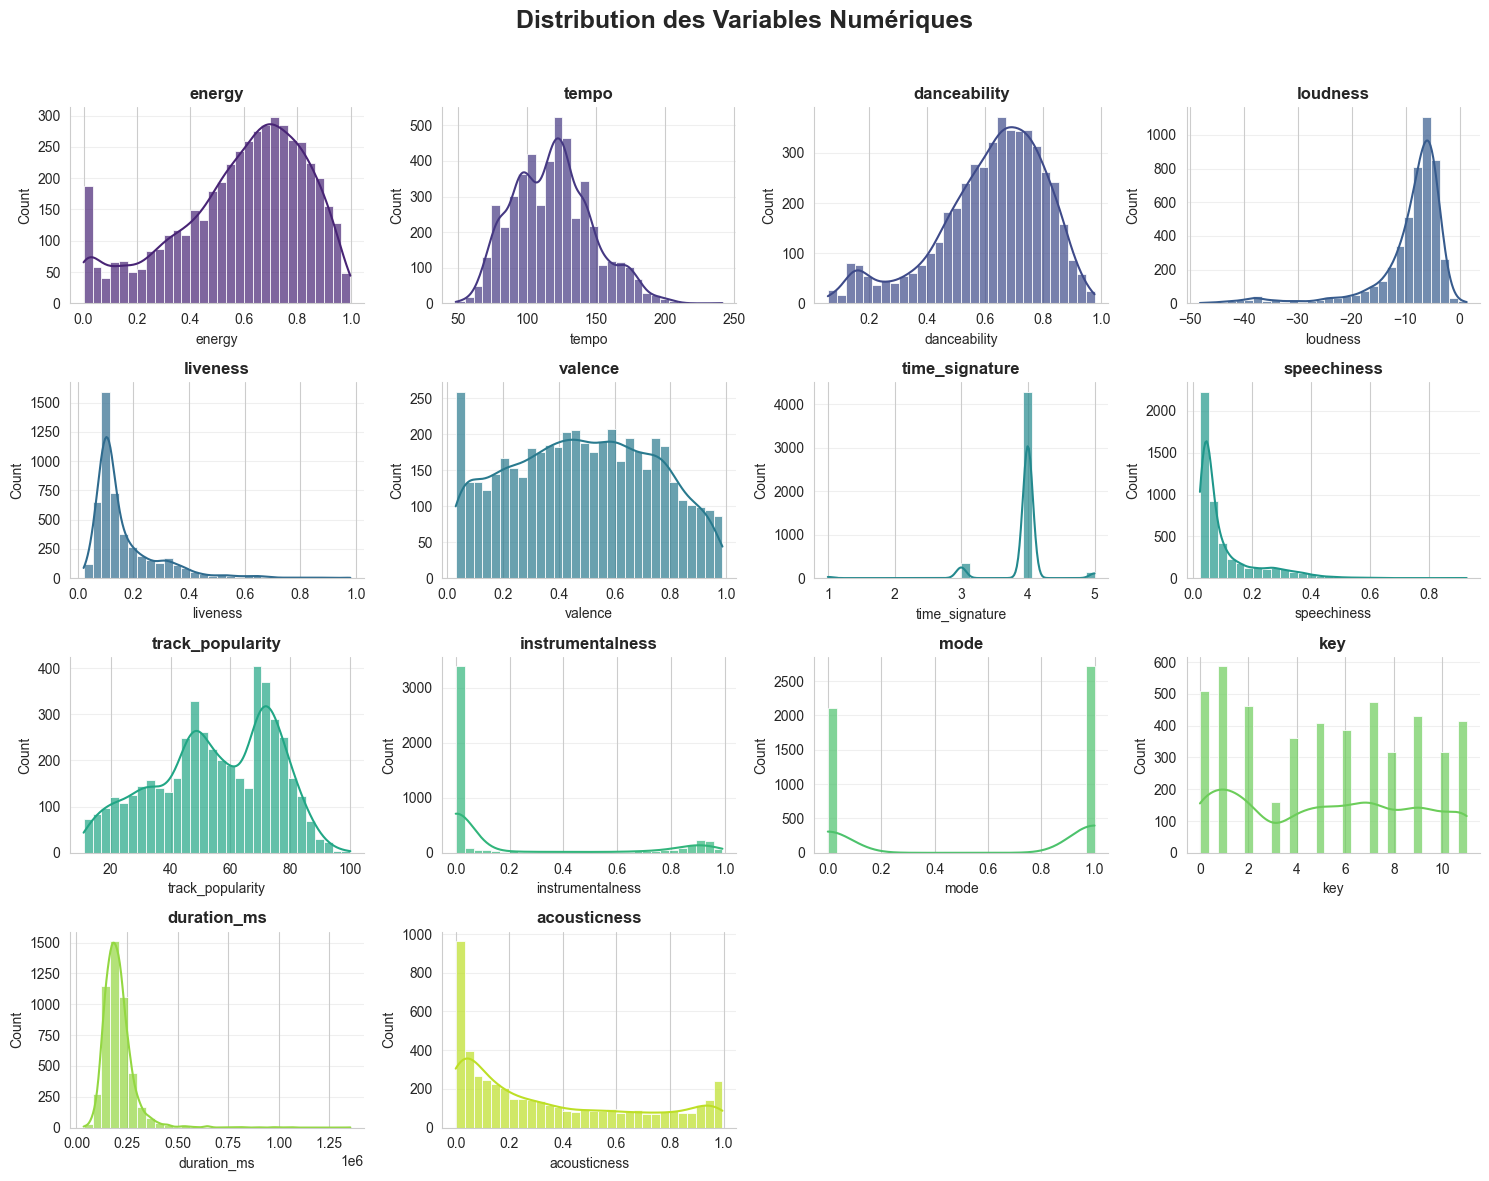

In [418]:
# Distribution des variables
plt.figure(figsize=(15, 12))
# Définir une palette de couleurs attrayante
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(numeric_cols)))
# Créer un subplot pour chaque variable numérique
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes):  # S'assurer qu'on ne dépasse pas le nombre de subplots
        # Histogramme avec densité
        sns.histplot(analyze[col], bins=30, kde=True, color=colors[i], ax=axes[i], edgecolor='white', alpha=0.7)
        axes[i].set_title(col, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        
# Masquer les axes supplémentaires si nécessaire
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Distribution des Variables Numériques", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuster pour le titre principal
plt.savefig('img/numeric_distributions.png', dpi=300, bbox_inches='tight')
#plt.close()

L'idée de cette visualisation est de voir s'il serait nécessaire de faire du **feature engineering**.

Voici ce qu'on pourrait faire:

1) **Loudness** : Cette variable présente une distribution très asymétrique négative. Une transformation logarithmique (en valeur absolue) pourrait normaliser sa distribution.
2) **Liveness** : Distribution fortement asymétrique positive avec une grande concentration près de 0. Une transformation log(1+x) serait appropriée.
3) **Instrumentalness** : Distribution bimodale extrême (beaucoup de valeurs près de 0 et quelques-unes près de 1). Une transformation binaire pourrait être plus adaptée (0 pour valeurs <0.5, 1 pour valeurs ≥0.5).
4) **Duration_ms** : Distribution fortement asymétrique positive. Une transformation logarithmique normaliserait cette distribution.
5) **Acousticness** : Distribution asymétrique positive. Une transformation logarithmique ou racine carrée pourrait l'améliorer.
6) **Speechiness** : Distribution très asymétrique positive. Une transformation log pourrait être utile.

<Figure size 1500x1200 with 0 Axes>

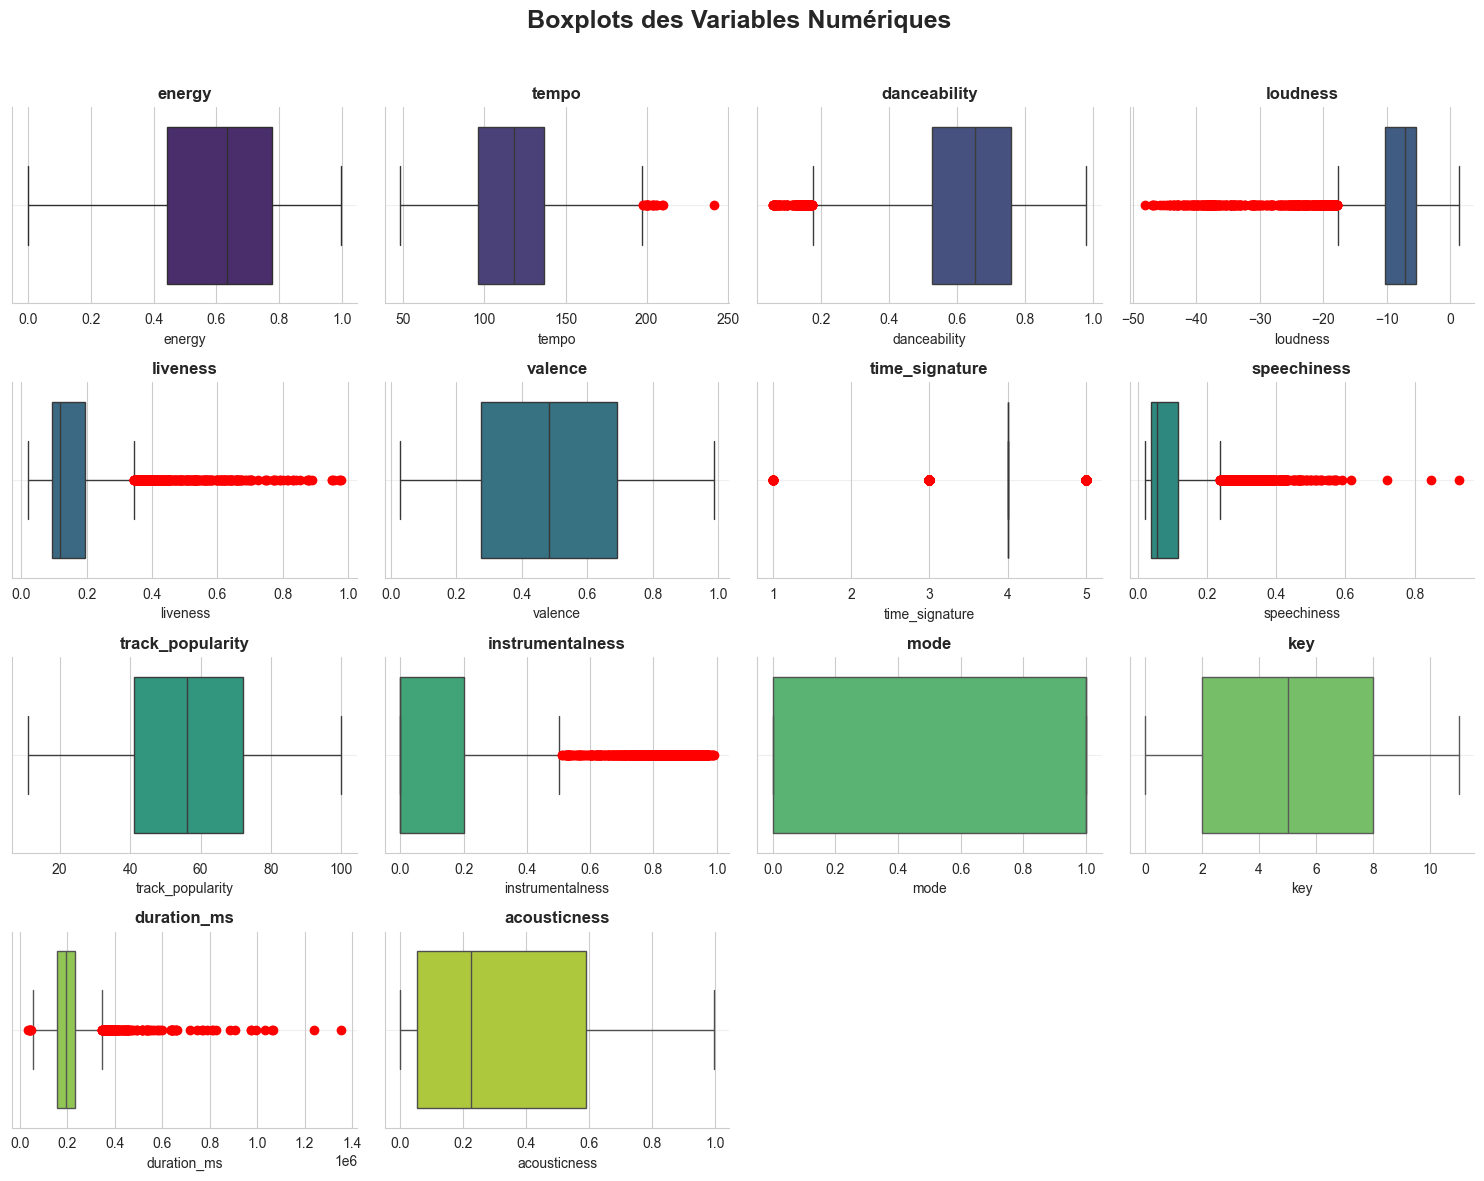

In [419]:
# Création de boxplots pour les variables numériques
plt.figure(figsize=(15, 12))
# Définir une palette de couleurs attrayante
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(numeric_cols)))
# Créer un subplot pour chaque variable numérique
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes):  # S'assurer qu'on ne dépasse pas le nombre de subplots
        # Boxplot avec outliers en rouge
        sns.boxplot(x=analyze[col], ax=axes[i], color=colors[i], flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'red'})
        axes[i].set_title(col, fontweight='bold')
        axes[i].grid(axis='y', alpha=0.3)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        
# Masquer les axes supplémentaires si nécessaire
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Boxplots des Variables Numériques", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuster pour le titre principal
plt.savefig('img/numeric_boxplots.png', dpi=300, bbox_inches='tight')
#plt.close()


On remarque qu'il existe probablement des outliers, il ne faudra pas oublier de les traiter avant modélisation

## **Feature engineering**

In [426]:
# Application des transformations suggérées pour normaliser les distributions

# 1. Loudness (transformation logarithmique en valeur absolue)
analyze['loudness_transformed'] = np.log1p(np.abs(analyze['loudness']))

# 2. Liveness (transformation log(1+x))
analyze['liveness_transformed'] = np.log1p(analyze['liveness'])

# 3. Instrumentalness (transformation binaire)
analyze['instrumentalness_binary'] = (analyze['instrumentalness'] >= 0.5).astype(int)

# 4. Duration_ms (transformation logarithmique)
analyze['duration_log'] = np.log(analyze['duration_ms'])

# 5. Acousticness (transformation logarithmique)
analyze['acousticness_transformed'] = np.log1p(analyze['acousticness'])

# 6. Speechiness (transformation logarithmique)
analyze['speechiness_transformed'] = np.log1p(analyze['speechiness'])


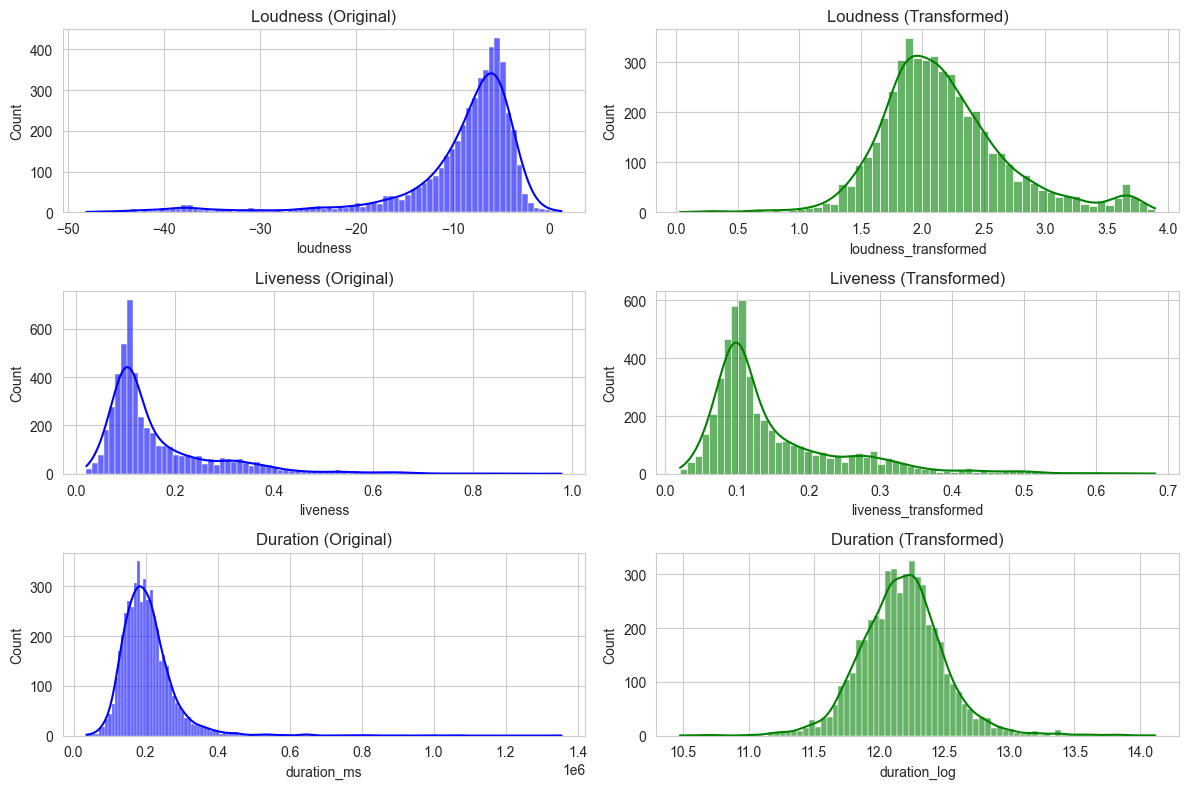

In [427]:
# Visualisation des distributions avant/après transformation
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

# Loudness
sns.histplot(analyze['loudness'], kde=True, ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title('Loudness (Original)')
sns.histplot(analyze['loudness_transformed'], kde=True, ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Loudness (Transformed)')

# Liveness
sns.histplot(analyze['liveness'], kde=True, ax=axes[2], color='blue', alpha=0.6)
axes[2].set_title('Liveness (Original)')
sns.histplot(analyze['liveness_transformed'], kde=True, ax=axes[3], color='green', alpha=0.6)
axes[3].set_title('Liveness (Transformed)')

# Duration
sns.histplot(analyze['duration_ms'], kde=True, ax=axes[4], color='blue', alpha=0.6)
axes[4].set_title('Duration (Original)')
sns.histplot(analyze['duration_log'], kde=True, ax=axes[5], color='green', alpha=0.6)
axes[5].set_title('Duration (Transformed)')

plt.tight_layout()
plt.savefig('img/transformed_distributions.png', dpi=300, bbox_inches='tight')

Les transformations ne sont pas parfaites, mais c'est déjà un bon début pour (peut-être) améliorer les modèles.

In [428]:
analyze.dtypes

energy                       float64
tempo                        float64
danceability                 float64
playlist_genre              category
loudness                     float64
liveness                     float64
valence                      float64
track_artist                category
time_signature               float64
speechiness                  float64
track_popularity               int64
track_album_name            category
playlist_name               category
analysis_url                category
track_name                  category
track_album_release_date    category
instrumentalness             float64
track_album_id              category
mode                         float64
key                          float64
duration_ms                  float64
acousticness                 float64
id                          category
playlist_subgenre           category
type                        category
playlist_id                 category
loudness_transformed         float64
l

- `playlist_genre` : on peut regarder le nombre de valeurs uniques et envisager dur OneHotEncoding
- `track_artist`: comme on a déjà un ID par playlist ou par album, on peut créer un ID par artsite. Cette variable sera probablement très significatives dans les futurs modèles
- `track_album_name`: à supprimer, trop de valeurs uniques pour envisager un OneHotEncoding
- `playlist_name`: à supprimer, trop de valeurs uniques pour envisager un OneHotEncoding
- `analysis_url`: à supprimer
- `track_id`: à supprimer (on a déjà l'ID)
- `track_name`: à supprimer, trop de valeurs uniques pour envisager un OneHotEncoding
- `track_album_release_date`: transformer le format date YYYY-MM-JJ à YYYYMMJJ (format numérique)
- `track_album_id`: passage de l'ID au format numérique
- `playlist_subgenre`: à supprimer, trop de valeurs uniques pour envisager un OneHotEncoding
- `type`: aucune information pertinente, seul une valeur "audio_features"
- `playlist_id`: passage de l'ID au format numérique


In [429]:
analyze["playlist_genre"].unique()

['pop', 'rock', 'jazz', 'classical', 'hip-hop', ..., 'wellness', 'gospel', 'funk', 'soca', 'disco']
Length: 35
Categories (35, object): ['afrobeats', 'ambient', 'arabic', 'blues', ..., 'soul', 'turkish', 'wellness', 'world']

Trop de valeurs uniques pour un OneHotEncoding, à supprimer.

In [431]:
# Création d'un ID numérique pour chaque artiste
artist_id_mapping = {artist: idx for idx, artist in enumerate(analyze['track_artist'].unique())}
analyze['artist_id'] = analyze['track_artist'].map(artist_id_mapping).astype(int)  # Changé de 'category' à int

# Compter le nombre de titres par artiste
artist_track_count = analyze['track_artist'].value_counts().to_dict()
analyze['artist_track_count'] = analyze['track_artist'].map(artist_track_count).astype(int)

# Création de variables binaires pour instrumentalness et liveness
analyze['is_instrumental'] = (analyze['instrumentalness'] > 0.5).astype(int)
analyze['is_live'] = (analyze['liveness'] > 0.8).astype(int)

# Fonction pour convertir les dates au format numérique
def convert_date_to_numeric(date_str):
    # Gestion des différents formats de date possibles
    if pd.isna(date_str):
        return 0
    
    # Suppression des tirets et conversion en entier
    date_str = str(date_str)
    if '-' in date_str:
        # Format YYYY-MM-DD
        return int(date_str.replace('-', ''))
    elif len(date_str) == 4:
        # Format YYYY
        return int(date_str) * 10000
    else:
        # Autre format ou valeur non valide
        return 0

# Fonction pour calculer l'âge des titres en jours
def calculate_age_days(date_str):
    if pd.isna(date_str):
        return 0
    
    date_str = str(date_str)
    try:
        if '-' in date_str:
            if len(date_str) >= 10:  # Format YYYY-MM-DD
                release_date = pd.to_datetime(date_str[:10])
            elif len(date_str) >= 7:  # Format YYYY-MM
                release_date = pd.to_datetime(date_str[:7] + '-01')
            else:  # Format YYYY
                release_date = pd.to_datetime(date_str[:4] + '-01-01')
        else:
            if len(date_str) == 4:  # Format YYYY
                release_date = pd.to_datetime(date_str + '-01-01')
            else:
                return 0
                
        # Calcul de la différence en jours
        today = pd.to_datetime('today')
        return (today - release_date).days
    except:
        return 0

# Création d'un ID numérique pour track_album_id
album_id_mapping = {album_id: idx for idx, album_id in enumerate(analyze['track_album_id'].unique())}
analyze['track_album_id_numeric'] = analyze['track_album_id'].map(album_id_mapping).astype(int)

# Création d'un ID numérique pour chaque playlist
playlist_id_mapping = {playlist_id: idx for idx, playlist_id in enumerate(analyze['playlist_id'].unique())}
analyze['playlist_id_numeric'] = analyze['playlist_id'].map(playlist_id_mapping).astype(int)

# Création d'un ID numérique pour chaque track
track_id_mapping = {track_id: idx for idx, track_id in enumerate(analyze['id'].unique())}
analyze['id_numeric'] = analyze['id'].map(track_id_mapping).astype(int)

# Transformation de track_album_release_date
# Conversion de la date en numérique et forçage du type en int
analyze['release_date_numeric'] = analyze['track_album_release_date'].apply(convert_date_to_numeric).astype(int)
analyze['track_age_days'] = analyze['track_album_release_date'].apply(calculate_age_days)

# Colonnes à supprimer
columns_to_drop = [
    'playlist_genre',
    'track_album_name',
    'playlist_name',
    'analysis_url',
    'track_name',
    'playlist_subgenre',
    'type',
    "track_album_release_date", 
    "track_artist", 
    "track_album_id",
    "playlist_id",
    "id"
]

# Suppression des colonnes
analyze = analyze.drop(columns=columns_to_drop)


In [432]:
analyze.dtypes

energy                      float64
tempo                       float64
danceability                float64
loudness                    float64
liveness                    float64
valence                     float64
time_signature              float64
speechiness                 float64
track_popularity              int64
instrumentalness            float64
mode                        float64
key                         float64
duration_ms                 float64
acousticness                float64
loudness_transformed        float64
liveness_transformed        float64
instrumentalness_binary       int64
duration_log                float64
acousticness_transformed    float64
speechiness_transformed     float64
artist_id                     int64
artist_track_count            int64
is_instrumental               int64
is_live                       int64
track_album_id_numeric        int64
playlist_id_numeric           int64
id_numeric                    int64
release_date_numeric        

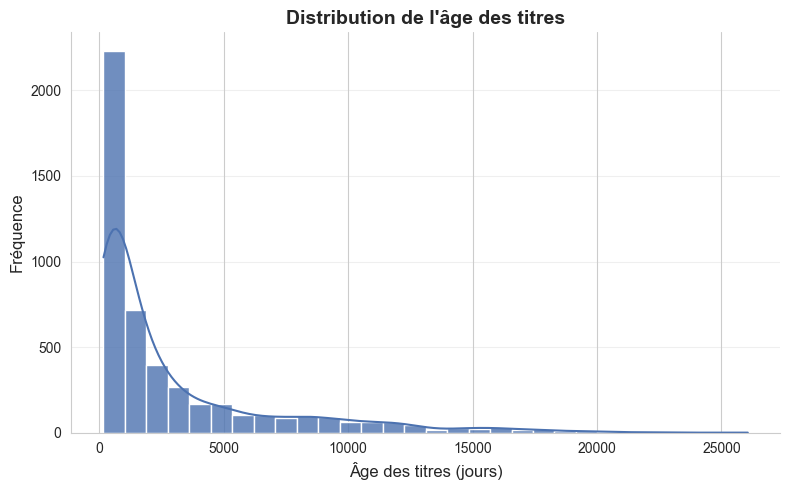

In [434]:
# Création d'un graphique  pour la distribution de l'âge des titres
plt.figure(figsize=(8, 5))
sns.histplot(
    analyze['track_age_days'], 
    bins=30, 
    kde=True,
    color='#4c72b0', 
    edgecolor='white',
    alpha=0.8
)
plt.title('Distribution de l\'âge des titres', fontsize=14, fontweight='bold')
plt.xlabel('Âge des titres (jours)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Amélioration du style des axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


On peut utiliser `id_numeric` comme index

In [435]:
# Définir l'index du dataset comme id_numeric
# Cela permettra d'avoir un identifiant unique pour chaque morceau
# qui servira d'index plutôt que d'être une variable utilisée dans les modèles

# Vérifier si id_numeric existe déjà dans le dataframe
if 'id_numeric' in analyze.columns:
    # Définir id_numeric comme index
    analyze.set_index('id_numeric', inplace=True)
    print("Index défini sur id_numeric")
else:
    # Si id_numeric n'existe pas, utiliser l'index actuel ou créer un nouvel index
    analyze.reset_index(inplace=True)
    analyze.rename(columns={'index': 'id_numeric'}, inplace=True)
    analyze.set_index('id_numeric', inplace=True)
    print("Nouvel index id_numeric créé")

# Afficher les 5 premières lignes pour vérifier
analyze.head()


Index défini sur id_numeric


,energy,tempo,danceability,loudness,liveness,valence,time_signature,speechiness,track_popularity,instrumentalness,...,acousticness_transformed,speechiness_transformed,artist_id,artist_track_count,is_instrumental,is_live,track_album_id_numeric,playlist_id_numeric,release_date_numeric,track_age_days
id_numeric,,,,,,,,,,,,,,,,,,,,,
0,0.592,157.969,0.521,-7.777,0.122,0.535,3.0,0.0304,100,0.0000,...,0.268499,0.029947,0,3,0,0,0,0,20240816,265
1,0.507,104.978,0.747,-10.171,0.117,0.438,4.0,0.0358,97,0.0608,...,0.182322,0.035174,1,10,0,0,1,0,20240517,356
2,0.808,108.548,0.554,-4.169,0.159,0.372,4.0,0.0368,93,0.0000,...,0.193921,0.036139,2,5,0,0,2,0,20241018,202
3,0.910,112.966,0.670,-4.070,0.304,0.786,4.0,0.0634,81,0.0000,...,0.089749,0.061471,3,11,0,0,3,0,20240823,258
4,0.783,149.027,0.777,-4.477,0.355,0.939,4.0,0.2600,98,0.0000,...,0.027907,0.231112,4,2,0,0,4,0,20241018,202


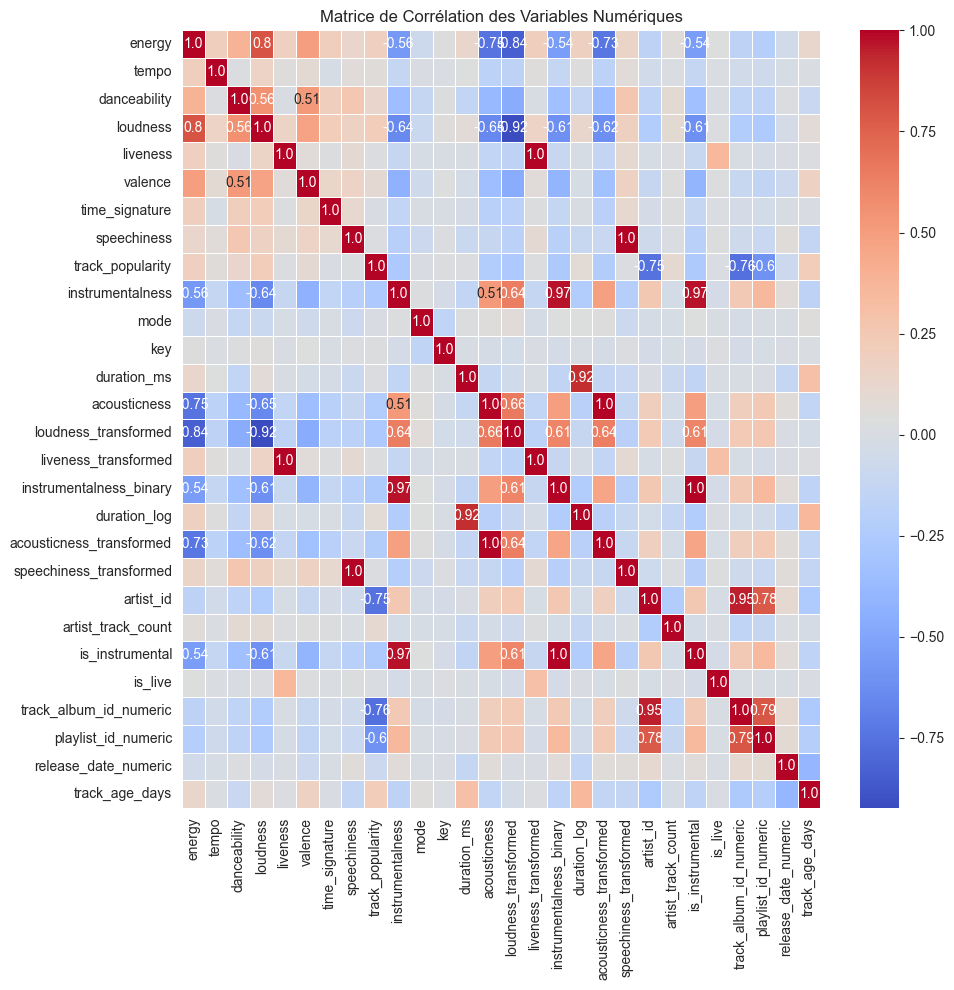

In [436]:
# Matrice de corrélation
plt.figure(figsize=(10, 10))
numeric_features = analyze.select_dtypes(include=[np.number]).columns
corr_matrix = analyze[numeric_features].corr()

# Création d'une matrice d'annotations conditionnelles
# Afficher uniquement les valeurs où la corrélation est > 0.5 en valeur absolue
annot_matrix = np.where(np.abs(corr_matrix) > 0.5, corr_matrix.round(2), "")

sns.heatmap(corr_matrix, annot=annot_matrix, fmt='', cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation des Variables Numériques")
plt.tight_layout()
#plt.savefig('img/correlation_matrix.png')

In [437]:
# Identification des variables fortement corrélées (|r| > 0.7)
# Récupérer les paires uniques de corrélations
strong_corr = corr_matrix.abs().unstack()
strong_corr = strong_corr[strong_corr > 0.7]
strong_corr = strong_corr[strong_corr < 1.0].dropna()

# Convertir en Series et trier
strong_corr_series = pd.Series(strong_corr)
strong_corr_series = strong_corr_series.sort_values(ascending=False)

print("\nVariables fortement corrélées (|r| > 0.7)")
print(strong_corr_series)


Variables fortement corrélées (|r| > 0.7)
speechiness_transformed   speechiness                 0.998334
speechiness               speechiness_transformed     0.998334
liveness                  liveness_transformed        0.996671
liveness_transformed      liveness                    0.996671
acousticness_transformed  acousticness                0.996122
acousticness              acousticness_transformed    0.996122
is_instrumental           instrumentalness            0.971568
instrumentalness_binary   instrumentalness            0.971568
instrumentalness          instrumentalness_binary     0.971568
                          is_instrumental             0.971568
track_album_id_numeric    artist_id                   0.954325
artist_id                 track_album_id_numeric      0.954325
loudness                  loudness_transformed        0.923868
loudness_transformed      loudness                    0.923868
duration_ms               duration_log                0.923174
duration_log

Les plus grosses corrélations (hors variables transformée) sont:
- `track_album_id_numeric` et `artist_id` : 0.95
- `energy` et `loudness`: 0.79
- `track_album_id_numeric` et `playlist_id_numeric`: 0.79
- `artist_id` et `playlist_id_numeric` : 0.78
- `track_popularity` et `track_album_id_numeric` : 0.76
- `track_popularity` et `artist_id` : 0.75
- `energy` et `acousticness`: 0.75

C'est intéressant de voir que la track_popularity est très corrélée à l'ID de l'artiste ou à l'ID de l'album. Cette variable `artist_id` va probablement améliorer notre modèle de façon significative.

In [438]:
analyze.columns


Index(['energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence',
       'time_signature', 'speechiness', 'track_popularity', 'instrumentalness',
       'mode', 'key', 'duration_ms', 'acousticness', 'loudness_transformed',
       'liveness_transformed', 'instrumentalness_binary', 'duration_log',
       'acousticness_transformed', 'speechiness_transformed', 'artist_id',
       'artist_track_count', 'is_instrumental', 'is_live',
       'track_album_id_numeric', 'playlist_id_numeric', 'release_date_numeric',
       'track_age_days'],
      dtype='object')

In [439]:
# Selection des features pour la modélisation - toutes les variables sauf l'index
# Récupération de toutes les colonnes numériques et catégorielles sauf id_numeric
features_model = [col for col in analyze.columns if col != 'id' and col != 'track_popularity']

# Définition des variables X et y
X = analyze[features_model].copy()
y = analyze['track_popularity'].copy()

# Division en ensembles d'entraînement et de test (85/15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## **Winsorisation & Scaling**

In [443]:
# Identification des variables numériques pour la winsorisation
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Winsorisation des variables numériques...")
for feature in numeric_features:
    # Exclure les variables binaires et les IDs qui ne nécessitent pas de winsorisation
    if feature.endswith('_binary') or feature.endswith('_id') or feature.endswith('_id_numeric'):
        continue
    
    # Appliquer la winsorisation avec des quantiles 5% et 95%
    X_train[feature], X_test[feature] = winsorize_data(X_train, X_test, feature)

print("\nWinsorisation terminée.")

# Vérification rapide des statistiques après winsorisation
print("\nStatistiques descriptives après winsorisation (échantillon d'entraînement):")
print(X_train.describe().T[['min', 'max', 'mean', 'std']])


Winsorisation des variables numériques...

Winsorisation terminée.

Statistiques descriptives après winsorisation (échantillon d'entraînement):
                                   min           max          mean  \
energy                    6.276075e-02  9.170000e-01  5.869569e-01   
tempo                     7.501955e+01  1.710637e+02  1.181960e+02   
danceability              1.960000e-01  8.710000e-01  6.217208e-01   
loudness                 -2.410747e+01 -3.425555e+00 -8.833044e+00   
liveness                  6.182775e-02  4.060000e-01  1.592785e-01   
valence                   5.602775e-02  9.010000e-01  4.784672e-01   
time_signature            3.000000e+00  4.000000e+00  3.922027e+00   
speechiness               2.930000e-02  3.297225e-01  9.707891e-02   
instrumentalness          0.000000e+00  9.300000e-01  2.036968e-01   
mode                      0.000000e+00  1.000000e+00  5.667641e-01   
key                       0.000000e+00  1.100000e+01  5.237329e+00   
duration_ms     

**On standardise après séparation train-test pour éviter le dataleak!!**

In [446]:
#Scaling features

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## **Modèles baselines**

In [460]:
# Modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")

# Modèle Régression Linéaire
lr_model = LinearRegression()
lr_model.fit(X_train_sc, y_train)
y_pred_lr = lr_model.predict(X_test_sc)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
print(f"Régression Linéaire MSE: {lr_mse:.4f}, R²: {lr_r2:.4f}")

Random Forest MSE: 70.3225, R²: 0.8243
Régression Linéaire MSE: 147.8592, R²: 0.6305


Le $R^2$ du Ranfom Forest est plus eleevé (0,82) que celui de la régression linéaire simple (0,63)

Le $R^2$ est déjà très elevé, juste par curiosité faisons le sans les variable `playlist_id_numeric`, `track_album_id_numeric` et `artist_id`:

In [453]:
# Création d'un nouveau jeu de données sans playlist_id_numeric et artist_id
X_train_reduced = X_train.drop(['playlist_id_numeric', 'artist_id',"track_album_id_numeric"], axis=1)
X_test_reduced = X_test.drop(['playlist_id_numeric', 'artist_id',"track_album_id_numeric"], axis=1)

# Standardisation des données réduites
scaler_reduced = StandardScaler()
X_train_reduced_sc = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_sc = scaler_reduced.transform(X_test_reduced)

# Modèle Random Forest sans les variables d'identifiants
rf_model_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_reduced.fit(X_train_reduced_sc, y_train)
y_pred_rf_reduced = rf_model_reduced.predict(X_test_reduced_sc)
rf_mse_reduced = mean_squared_error(y_test, y_pred_rf_reduced)
rf_r2_reduced = r2_score(y_test, y_pred_rf_reduced)
print(f"Random Forest sans ID - MSE: {rf_mse_reduced:.4f}, R²: {rf_r2_reduced:.4f}")

# Modèle Régression Linéaire sans les variables d'identifiants
lr_model_reduced = LinearRegression()
lr_model_reduced.fit(X_train_reduced_sc, y_train)
y_pred_lr_reduced = lr_model_reduced.predict(X_test_reduced_sc)
lr_mse_reduced = mean_squared_error(y_test, y_pred_lr_reduced)
lr_r2_reduced = r2_score(y_test, y_pred_lr_reduced)
print(f"Régression Linéaire sans ID - MSE: {lr_mse_reduced:.4f}, R²: {lr_r2_reduced:.4f}")

Random Forest sans ID - MSE: 261.3451, R²: 0.3469
Régression Linéaire sans ID - MSE: 333.8732, R²: 0.1657


Juste sur les modèles baseline, on peut déjà dire que connaître l'artiste, l'album et la playlist du morceau aide énormément pour prédire la popularité.

## **Interpréter le modèle linéaire**

In [465]:
coef_df = pd.DataFrame({
    'Variable': X_train.columns,  # attention ici il faut utiliser les noms non scalés
    'Coefficient': lr_model.coef_
})

print(coef_df)


                    Variable  Coefficient
0                     energy    -1.009607
1                      tempo     0.314763
2               danceability     0.799636
3                   loudness    -6.920033
4                   liveness     3.957788
5                    valence    -0.658744
6             time_signature    -0.680267
7                speechiness    -6.080748
8           instrumentalness    -0.758034
9                       mode    -0.262968
10                       key     0.253732
11               duration_ms    -5.623314
12              acousticness    -1.320972
13      loudness_transformed    -8.533161
14      liveness_transformed    -3.924245
15   instrumentalness_binary     0.001609
16              duration_log     6.262753
17  acousticness_transformed     0.281758
18   speechiness_transformed     5.328549
19                 artist_id    -6.367373
20        artist_track_count    -0.350110
21           is_instrumental     0.001609
22                   is_live     0



**Coefficients à fort impact positif**

* **Release date (numérique) (15.02)** :
  Les morceaux plus récents sont nettement plus populaires.

* **Track age (en jours) (15.32)** :
  Paradoxalement, l'ancienneté d'un morceau est également positivement corrélée à la popularité, suggérant que les titres qui "survivent" dans le temps gagnent en popularité.

* **Duration (log transformé) (6.26)** :
  La durée du morceau, une fois transformée logarithmiquement, a un effet positif significatif sur la popularité.

* **Speechiness (transformée) (5.33)** :
  La présence de paroles (après transformation) est positivement associée à la popularité.

* **Liveness (3.96)** :
  Les morceaux qui donnent l'impression d'être joués en live sont plus populaires.


**Coefficients à fort impact négatif**

* **Track album ID (numérique) (-9.05)** :
  Certains albums sont associés à une popularité moindre.

* **Loudness (transformée) (-8.53)** :
  L'intensité sonore, après transformation, a un impact négatif important.

* **Loudness (brute) (-6.92)** :
  De même, la mesure brute du volume sonore est négativement corrélée avec la popularité.

* **Artist ID (-6.37)** :
  L'identité de l'artiste peut fortement diminuer la popularité de certains morceaux.

* **Speechiness (brute) (-6.08)** :
  La mesure brute de la présence de paroles est corrélée négativement avec la popularité.

* **Duration (en millisecondes) (-5.62)** :
  La durée brute des morceaux est également négativement corrélée à la popularité.


## **Tuner le Random Forest**

In [468]:
# Définition de la grille de paramètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialisation du modèle de base
rf = RandomForestRegressor(random_state=42)

# Configuration du Grid Search avec validation croisée à 5 plis
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Exécution du Grid Search
print("Démarrage du Grid Search...")
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés:")
print(grid_search.best_params_)

Démarrage du Grid Search...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

Meilleur modèle:

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 500],  # Plus d'arbres
    'max_depth': [5, 10, 20, 30, 40],  # Profondeur maximale
    'min_samples_split': [2, 5, 10,15],  # Taille min de split
    'min_samples_leaf': [2,4,6,8],  # Taille min des feuilles
    'max_features' : ['sqrt'],
    'criterion': ['squared_error',"absolute_error"]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Teste 30 configurations
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1   ,
    verbose=2,
    random_state=42
)



random_search.fit(X_train_sc, y_train)
print("Meilleurs paramètres (RandomizedSearch) :", random_search.best_params_)